# Base Learners

Julian Domingo - jad5348

This file contains my process for training my base learners and meta learner to predict the probability values for the target value **Y**.

In [89]:
# Computation / Data Analysis stuff
import numpy as np
import pandas as pd
from scipy.stats import skew, probplot, norm, uniform, randint
from scipy.special import boxcox1p

# Modeling stuff
from mlens.metrics import make_scorer
from mlens.model_selection import Evaluator
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import (GridSearchCV, 
                                     StratifiedKFold,
                                     cross_val_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier, 
                              ExtraTreesClassifier,
                              BaggingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, KFold

# Plotting stuff
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mlens.visualization import corrmat
from pandas.tools.plotting import scatter_matrix

# Plotting visuals stuff
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

# ignore warnings (i.e. deprecation warnings)
import warnings
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [90]:
test_ids = pd.read_csv("./data/raw/test.csv")[["id"]]
train_y_cp = pd.read_csv("./data/raw/train.csv")["Y"]

## Helper Functions

In [91]:
def get_preds(filename):
    train = pd.read_csv("./meta_features/train/train_{}.csv".format(filename), index_col=0).as_matrix().ravel()
    test = pd.read_csv("./meta_features/test/test_{}.csv".format(filename), index_col=0).as_matrix().ravel()
    
    return train, test


def get_data(filename):
    train = pd.read_csv("./data/refined/train/train_{}.csv".format(filename))
    test = pd.read_csv("./data/refined/test/test_{}.csv".format(filename))
    
    x_train = train.drop(["Y"], axis = 1)
    y_train = train["Y"]
    
    return train, test, x_train, y_train

In [92]:
train_raw, test_raw, x_train_raw, y_train_raw = get_data("raw")
train_base, test_base, x_train_base, y_train_base = get_data("base")
train_log, test_log, x_train_log, y_train_log = get_data("log")
train_poly, test_poly, x_train_poly, y_train_poly = get_data("poly")
train_scaled, test_scaled, x_train_scaled, y_train_scaled = get_data("scaled")
train_reduced, test_reduced, x_train_reduced, y_train_reduced = get_data("reduced")

In [93]:
x_train_base.head()

,F2,F3,F4,F5,F6,F7,F8,F10,F11,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24
0,61385,0,38,118751,1000,32020,1,127959,1,1,119757,119100,1,118830,1,1,126461,1,46871
1,51329,0,41,120800,1000,130630,1,128342,2,1,138110,121149,1,118832,1,1,130296,1,42386
2,5522,0,50,118779,1000,303218,2,128299,1,1,119777,119126,1,118832,1,2,127063,1,23968
3,6754,0,45,123163,2000,19024,1,127968,1,2,270637,123511,1,118832,1,1,15274,1,27555
4,16991,0,41,119193,1000,303218,1,128299,1,1,119777,119542,1,118832,1,1,133491,1,50260


In [94]:
def show_pearson_corr(mapping, dict_vals_are_models=True):
    if dict_vals_are_models:
        all_preds = pd.DataFrame(np.zeros((test_base.shape[0], len(mapping))), columns=list(mapping.keys()))
    else:
        all_preds = pd.DataFrame(np.zeros((train_base.shape[0], len(mapping))), columns=list(mapping.keys()))
    
    for name, val in mapping.items():
        if dict_vals_are_models:
            val.fit(x_train_base, y_train_base)
            all_preds[name] = val.predict_proba(test_base)[:,1]   
        else:
            all_preds[name] = val
        
    all_preds = all_preds.reindex_axis(sorted(all_preds.columns.values), axis=1)

    ax = corrmat(all_preds.corr())
    plt.show()

## Modeling Functions

In [95]:
def get_cross_val_score(model, x_train, y_train, n_folds, run_parallel=True):
    if run_parallel:
        cv = cross_val_score(model, x_train, y_train, cv = n_folds, scoring = "roc_auc", n_jobs = -1)
    else:
        cv = cross_val_score(model, x_train, y_train, cv = n_folds, scoring = "roc_auc")
        
    print("Cross validation score: {} +/- {}\nRaw scores: {}".format(str(np.mean(cv)), str(np.std(cv)), str(cv)))
    return cv


def train_and_save_base_learner_preds(model, folds, x_train, y_train, test, pred_filename, timeit=True, mlens=False):
    # Train model on the folds defined
    if mlens:
        train_ids = x_train.index
        test_ids = test.index
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        test = np.array(test)
        
        train_preds = np.zeros(x_train.shape[0])
        test_preds = np.zeros(test.shape[0])
        test_preds_iter = np.zeros((test.shape[0], len(folds)))
        
        stacker = SuperLearner(random_state=seed, scorer=roc_auc_score)
        stacker.add(model, proba=True)
        
        for i, (train_indices, test_indices) in enumerate(folds):
            xtr = x_train[train_indices]
            xhold = x_train[test_indices]
            ytr = y_train[train_indices]
            
            # Deletes the previous fit when "warm_start" is disabled (intended behavior)
            %time stacker.fit(x_train, y_train)
            
            train_preds[test_indices] = stacker.predict_proba(xhold)[:,1]
            test_preds_iter[:,i] = stacker.predict_proba(test)[:,1]
        
        test_preds[:] = test_preds_iter.mean(1)
        
        submission = pd.DataFrame({"id": train_ids, "Y": train_preds})
        submission.to_csv("./meta_features/mlens/train/train_{}.csv".format(pred_filename), index=False, columns=["id", "Y"])   
        
        submission = pd.DataFrame({"id": test_ids, "Y": test_preds})
        submission.to_csv("./meta_features/mlens/test/test_{}.csv".format(pred_filename), index=False, columns=["id", "Y"])   
        
        return model  
    
    else:
        result = generate_out_of_folds_preds(model, folds, x_train, y_train, test, timeit)

        train_preds_csv = pd.DataFrame(columns=["Y"], index=x_train.index, data=result["train_preds"])
        train_preds_csv.to_csv("./meta_features/train/train_{}.csv".format(pred_filename), index=False, columns=["id", "Y"])

        test_preds_csv = pd.DataFrame(columns=["Y"], index=test.index, data=result["test_preds"])
        test_preds_csv.to_csv("./meta_features/test/test_{}.csv".format(pred_filename), index=False, columns=["id", "Y"])

        return result["model"]
                          

def generate_out_of_folds_preds(model, folds, x, y, test, timeit=True):
    """ 
    Trains the model through (stratified) CV, and generates predictions from
    the weighted average of each holdout's predictions.
    
    'train_preds' is the combination of all predictions from each holdout.
    'test_preds' is the final predictions computed through the mean of each test prediction.
    
    """
    x = np.array(x)
    y = np.array(y)
    test = np.array(test)
        
    train_preds = np.zeros(x.shape[0])
    test_preds = np.zeros(test.shape[0])
    test_preds_iter = np.zeros((test.shape[0], len(folds)))
    
    for i, (train_indices, test_indices) in enumerate(folds):
        x_train = x[train_indices]
        x_holdout = x[test_indices]
        y_train = y[train_indices]
        
        if timeit:
            %time model.fit(x_train, y_train)
        else:
            model.fit(x_train, y_train)
        
        train_preds[test_indices] = model.predict_proba(x_holdout)[:,1]
        test_preds_iter[:,i] = model.predict_proba(test)[:,1]
        
    test_preds[:] = test_preds_iter.mean(1)
        
    return {'model': model, 'train_preds': train_preds ,'test_preds': test_preds}

In [96]:
# Obtain fold indices for base learner training.
n_splits = 5
folds = list(StratifiedKFold(n_splits, random_state=seed).split(x_train_base, y_train_base))

Note that we want to use the **same** fold indices every time to reduce overfitting. 

# Base Learners

### Random Forest Classifier

Tuning parameters
    * n_estimators (online): "n_estimators is not really worth optimizing. The more estimators you give it, the better it will do. 500 or 1000 is usually sufficient." -- stack overflow
    * criterion (class): Constantine mentioned entropy is the preferred criterion for Random Forests.
    * max_features (code): used GridSearchCV, sci-kit learn docs showed [1, 3, 10] as good contenders.
    * max_depth (observation): It seems like limiting the max depth of the classifier inhibits on the predictive capabilities, as my submission with default max_depth produced a higher public leaderboard score. (~0.1 higher)

In [30]:
rfc_log = RandomForestClassifier(criterion='entropy', max_features=10, n_estimators=1000, n_jobs=-1)
rfc_log = train_and_save_base_learner_preds(rfc_log, folds, x_train_log, y_train_log, test_log, "random_forest_log")
rfc_log_cv = get_cross_val_score(rfc_log, x_train_log, y_train_log, n_splits)

CPU times: user 1min, sys: 386 ms, total: 1min
Wall time: 9.53 s
CPU times: user 1min 1s, sys: 350 ms, total: 1min 2s
Wall time: 9.71 s
CPU times: user 1min 1s, sys: 337 ms, total: 1min 2s
Wall time: 9.67 s
CPU times: user 1min 4s, sys: 339 ms, total: 1min 4s
Wall time: 9.94 s
CPU times: user 1min 4s, sys: 355 ms, total: 1min 4s
Wall time: 10 s
Cross validation score: 0.763972140277 +/- 0.0126201727415
Raw scores: [ 0.76663797  0.77985633  0.74617437  0.75311065  0.77408139]


###### Using Raw Data

In [70]:
rfc_raw = RandomForestClassifier(criterion='entropy', max_features=10, n_estimators=1000, n_jobs=-1)

In [73]:
# Using tuned parameters fitted on BASE data
rfc_raw = train_and_save_base_learner_preds(rfc_raw, folds, x_train_raw, y_train_raw, test_raw, "random_forest_raw", timeit=False)
rfc_raw_cv = get_cross_val_score(rfc_raw, x_train_raw, y_train_raw, n_splits)

Cross validation score: 0.7695456125591551 +/- 0.012976891105761897
Raw scores: [0.76927927 0.78441299 0.75467399 0.7555443  0.78381751]


In [74]:
# Finally, predict our probabilities.
rfc_raw.fit(x_train_raw, y_train_raw)
rfc_raw_probs = rfc_raw.predict_proba(test_raw)[:,1]
print rfc_raw_probs

[0.97  0.675 0.93  ... 0.852 0.995 0.972]


In [53]:
# save a copy of the predictions
submission = pd.DataFrame({"id": test_ids.id, "Y": rfc_raw_probs})
submission.to_csv("./submissions/random_forest_raw_lone.csv", index=False, columns=["id", "Y"])

###### Using Polynomial Transformation Data

In [35]:
rfc_poly = RandomForestClassifier(criterion='entropy', max_features=10, n_estimators=1000, n_jobs=-1)
rfc_poly = train_and_save_base_learner_preds(rfc_poly, folds, x_train_poly, y_train_poly, test_poly, "random_forest_poly")
rfc_poly_cv = get_cross_val_score(rfc_poly, x_train_poly, y_train_poly, n_splits)

CPU times: user 1min 32s, sys: 413 ms, total: 1min 32s
Wall time: 16.1 s
CPU times: user 1min 38s, sys: 398 ms, total: 1min 39s
Wall time: 14.5 s
CPU times: user 1min 36s, sys: 408 ms, total: 1min 37s
Wall time: 15.3 s
CPU times: user 1min 38s, sys: 646 ms, total: 1min 39s
Wall time: 15.6 s
CPU times: user 1min 40s, sys: 555 ms, total: 1min 41s
Wall time: 15 s
Cross validation score: 0.762157532882 +/- 0.0178247735886
Raw scores: [ 0.74675429  0.78349288  0.74934748  0.74677624  0.78441678]


###### Using Base Data

In [36]:
rfc_param_grid = {
    "max_features": [1, 3, 10]
}

rfc = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=1000, n_jobs=-1)

gs_rfc = GridSearchCV(estimator=rfc, param_grid=rfc_param_grid, cv=n_splits, scoring="roc_auc")
gs_rfc.fit(x_train_base, y_train_base)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'auto'], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [41]:
# So, we'll use 10 to be our max_features value.
print gs_rfc.best_params_

{'max_features': 6, 'max_depth': 12}


In [130]:
# Train with our optimized parameters.
rfc = RandomForestClassifier(criterion='entropy', max_features=10, n_estimators=1000, n_jobs=-1)
rfc = train_and_save_base_learner_preds(rfc, folds, x_train_base, y_train_base, test_base, "random_forest_base")
rf_cv = get_cross_val_score(rfc, x_train_base, y_train_base, n_splits)

Cross validation score: 0.767653985688 +/- 0.0137592880393
Raw scores: [ 0.76729217  0.78474473  0.74785336  0.7578412   0.78053847]


In [131]:
# Finally, predict our probabilities.
rfc.fit(x_train_base, y_train_base)
rfc_probs = rfc.predict_proba(test_base)[:,1]
print rfc_probs

[ 0.971  0.684  0.929 ...,  0.862  0.987  0.968]


In [132]:
# save a copy of the predictions
submission = pd.DataFrame({"id": test_ids.id, "Y": rfc_probs})
submission.to_csv("./submissions/random_forest_base_lone.csv", index=False, columns=["id", "Y"])

###### Using Log Data

In [54]:
rfc_log = RandomForestClassifier(criterion='entropy', max_features=10, n_estimators=1000, n_jobs=-1)
rfc_log = train_and_save_base_learner_preds(rfc_log, folds, x_train_log, y_train_log, test_log, "random_forest_log")
rfc_log_cv = get_cross_val_score(rfc_log, x_train_log, y_train_log, n_splits)

CPU times: user 1min 2s, sys: 511 ms, total: 1min 2s
Wall time: 10.8 s
CPU times: user 1min 4s, sys: 512 ms, total: 1min 4s
Wall time: 11 s
CPU times: user 1min 4s, sys: 498 ms, total: 1min 5s
Wall time: 10.7 s
CPU times: user 1min 4s, sys: 308 ms, total: 1min 5s
Wall time: 10.1 s
CPU times: user 1min 5s, sys: 413 ms, total: 1min 5s
Wall time: 10.4 s
Cross validation score: 0.766020138462 +/- 0.0113610765781
Raw scores: [ 0.76509741  0.77783124  0.75289286  0.75429075  0.77998842]


Oddly enough, the raw / no feature engineering data set has the highest public LB score when submitted to kaggle. However, this could potentially be overfitting with how much noise there is in the raw / no feature engineering data set.

Let's see what features RandomForestClassifier deemed most important.

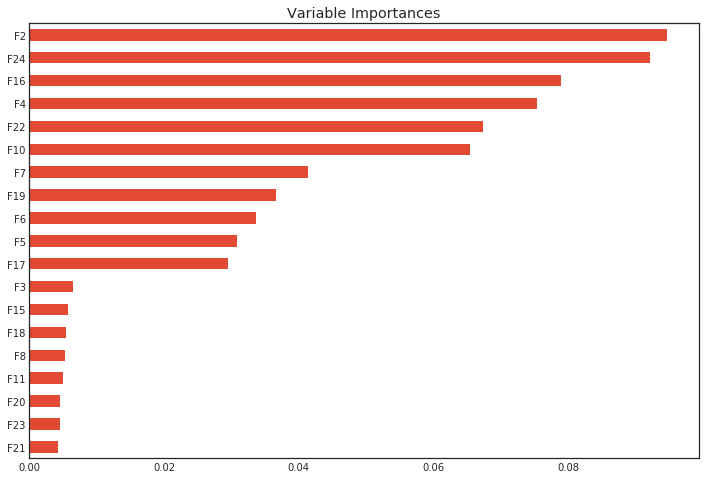

In [88]:
pd.Series(index=x_train_raw.columns, data=rfc_raw.feature_importances_) \
    .drop(["F1", "F9", "F12", "F13", "F14"]) \
    .sort_values().plot(kind='barh', title='Variable Importances')

Thus, we'll use the top 2 features, **F2** and **F24**, to use in our PolynomialFeature transformed data set. Generation of this data set can be found in **"data_processing.ipynb"** under the "Transformations" subsection.

### Logistic Regressor

Tuning Parameters
    * solver (online): according to docs, "For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and 
        ‘saga’ are faster for large ones."
    * tol (observation): with the default being 1e-4, I decided giving a little leeway in both directions would be good to observe.
    * C (online): according to sklearn, "Large values of C give more freedom to the model. Conversely, smaller values of C constrain the model more."

In [137]:
lr_param_grid = {
    "tol": [1e-5, 1e-4, 1e-3],
    "solver": ["liblinear", "sag"], # For some reason, "saga" isn't allowed anymore.
    "C": [0.01, 0.1, 1.0, 10, 100] # Inverse of regularization strength. Smaller values specify stronger regularization (must be pos float)
}

lr = LogisticRegression()

gs_lr = GridSearchCV(estimator=lr, param_grid=lr_param_grid, cv=n_splits, scoring="roc_auc")
gs_lr.fit(x_train_log, y_train_log)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1.0, 10, 100], 'tol': [1e-05, 0.0001, 0.001], 'solver': ['liblinear', 'sag']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [140]:
print gs_lr.best_params_
print gs_lr.best_score_

{'C': 100, 'tol': 1e-05, 'solver': 'liblinear'}
0.545830385785


In [156]:
# Train with our optimized parameters.
lr = LogisticRegression(C=100, tol=1e-05, solver="liblinear")
lr = train_and_save_base_learner_preds(lr, folds, x_train_log, y_train_log, test_log, "logistic_regression_log")
lr_cv = get_cross_val_score(lr, x_train_log, y_train_log, n_splits)

Cross validation score: 0.545833322926 +/- 0.0230976755653
Raw scores: [ 0.56433684  0.55349304  0.50612     0.53532381  0.56989291]


In [157]:
# Finally, predict our probabilities.
lr.fit(x_train_log, y_train_log)
lr_probs = lr.predict_proba(test_log)[:,1]
print lr_probs

[ 0.91999531  0.93921733  0.91854823 ...,  0.92974219  0.92594105
  0.94791889]


In [158]:
# save a copy of the predictions
submission = pd.DataFrame({"id": test_ids.id, "Y": lr_probs})
submission.to_csv("./submissions/logistic_regression_lone.csv", index=False, columns=["id", "Y"])

The logistic regressor scores are pretty bad, both in offline CV and when submitted to Kaggle. I'll choose to leave this base learner out of my ensemble.

### XGBoost

Tuning Parameters: all final chosen parameters for XGBoost are documented below.

For XGBoost, I'll train several instances of the model on different transforms of the data set:
    * With base data
    * With polynomial features
    * Bagged classifier (using XGB as base learner, fitted with base data)
    
But first, I'll go through my tuning process for choosing my XGBoost parameters.

###### Step 1: Optimize learning_rate & n_estimators
1. max_depth = 5 : This should be between 3-10. I’ve started with 5.
2. min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
3. gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
4. subsample & colsample_bytree = 0.8 : This is a commonly used start value. Typical values range between 0.5-0.9.
5. scale_pos_weight = 1: Because of high class imbalance

In [97]:
def model_fit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50, show_output=True):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, train_y_cp)
        
        if show_output:
            cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, \
                              metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        else:
            cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
            
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], train_y_cp, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    if show_output:
        #Print model report:
        print ("\nModel Report")
        print ("Accuracy : {}".format(metrics.accuracy_score(train_y_cp, dtrain_predictions)))
        print ("AUC Score (Train): {}".format(metrics.roc_auc_score(train_y_cp, dtrain_predprob)))
        # .get_booster().get_score(importance_type='weight')
        # feat_imp = pd.Series(alg._Booster().get_fscore()).sort_values(ascending=False)
        feat_imp = pd.Series(alg.get_booster().get_score(importance_type="weight")).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [98]:
# Initial xgb parameters
xgb_base_params = {
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 5,
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": 'binary:logistic', # Used for classifier XGB
    "nthread": 4,
    "scale_pos_weight": 1,
    "seed": seed
}

[0]	train-auc:0.598089+0.0141979	test-auc:0.565919+0.0203243
[1]	train-auc:0.638271+0.0137126	test-auc:0.60012+0.0184288
[2]	train-auc:0.658802+0.0177463	test-auc:0.613642+0.0164839
[3]	train-auc:0.670629+0.0206667	test-auc:0.620431+0.0175085
[4]	train-auc:0.679858+0.0271329	test-auc:0.619132+0.0215458
[5]	train-auc:0.686931+0.0274203	test-auc:0.627745+0.01916
[6]	train-auc:0.699647+0.0210782	test-auc:0.631104+0.0157135
[7]	train-auc:0.708459+0.022327	test-auc:0.635924+0.0189767
[8]	train-auc:0.715601+0.0192213	test-auc:0.641783+0.0155102
[9]	train-auc:0.723321+0.0141541	test-auc:0.649355+0.0103319
[10]	train-auc:0.732172+0.00947029	test-auc:0.653931+0.00916104
[11]	train-auc:0.739927+0.0111418	test-auc:0.658629+0.0100949
[12]	train-auc:0.747702+0.00835335	test-auc:0.661979+0.00712129
[13]	train-auc:0.756037+0.0124843	test-auc:0.666299+0.0118047
[14]	train-auc:0.758687+0.00985301	test-auc:0.66836+0.0102543
[15]	train-auc:0.762982+0.0129228	test-auc:0.672456+0.0108429
[16]	train-auc:0.7

[132]	train-auc:0.95313+0.00329087	test-auc:0.732122+0.0161699
[133]	train-auc:0.953695+0.00339308	test-auc:0.732433+0.0165753
[134]	train-auc:0.954002+0.00332642	test-auc:0.732987+0.016979
[135]	train-auc:0.954451+0.00315488	test-auc:0.731952+0.0167035
[136]	train-auc:0.954953+0.00309231	test-auc:0.732487+0.0167991
[137]	train-auc:0.955374+0.00288676	test-auc:0.732627+0.0166042
[138]	train-auc:0.955874+0.00274683	test-auc:0.73267+0.0162369
[139]	train-auc:0.956198+0.00282647	test-auc:0.732852+0.0162506
[140]	train-auc:0.956831+0.00280083	test-auc:0.733622+0.0164865
[141]	train-auc:0.957167+0.00281118	test-auc:0.733969+0.016484
[142]	train-auc:0.957695+0.00253038	test-auc:0.734038+0.0168361
[143]	train-auc:0.958251+0.00237433	test-auc:0.734323+0.0165391
[144]	train-auc:0.958585+0.00232573	test-auc:0.734273+0.0162076
[145]	train-auc:0.959095+0.00222646	test-auc:0.734445+0.0157094
[146]	train-auc:0.959509+0.00223675	test-auc:0.734806+0.0162584
[147]	train-auc:0.959709+0.0022814	test-auc:

[261]	train-auc:0.986029+0.000755319	test-auc:0.738971+0.01786
[262]	train-auc:0.986113+0.000750886	test-auc:0.739214+0.0180104
[263]	train-auc:0.986246+0.000677076	test-auc:0.739131+0.01784
[264]	train-auc:0.986274+0.000688706	test-auc:0.739113+0.0179996
[265]	train-auc:0.986415+0.000657687	test-auc:0.739048+0.018036
[266]	train-auc:0.986564+0.000619917	test-auc:0.739248+0.0183644
[267]	train-auc:0.986659+0.000590378	test-auc:0.739163+0.0182311
[268]	train-auc:0.986791+0.000636739	test-auc:0.739095+0.0181338
[269]	train-auc:0.986925+0.000465246	test-auc:0.739418+0.0176853
[270]	train-auc:0.987021+0.000428226	test-auc:0.739252+0.0174768
[271]	train-auc:0.98715+0.000426625	test-auc:0.739574+0.0173005
[272]	train-auc:0.987232+0.000422287	test-auc:0.739563+0.0177112
[273]	train-auc:0.987416+0.000450844	test-auc:0.739853+0.0177603
[274]	train-auc:0.987479+0.000459616	test-auc:0.739797+0.0175052
[275]	train-auc:0.987554+0.000443795	test-auc:0.739895+0.0178354
[276]	train-auc:0.987698+0.0004

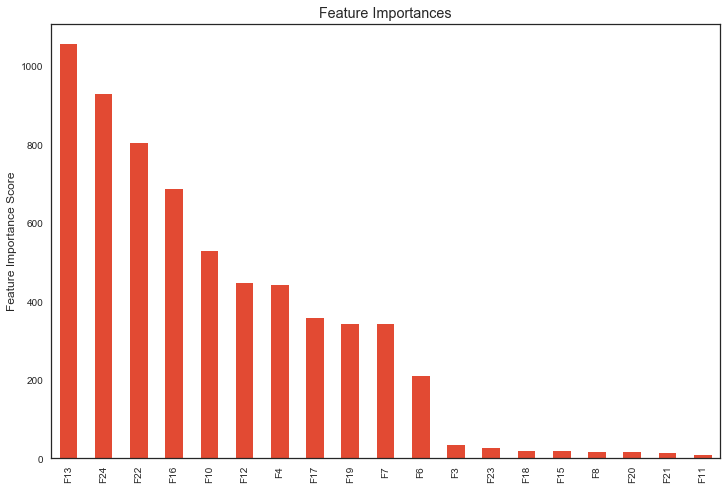

In [286]:
xgb_base = XGBClassifier(**xgb_base_params)
model_fit(xgb_base, x_train_base, x_train_base.columns.values)

It's clear that **345** is an optimal value for *n_estimators* for a learning rate of **0.1** (running xgb.cv() stops at the estimator with the highest cv score).

Also note that XGBoost also places **F24** and **F13** as the most important features, which validates our decision to use these features for our PolynomialFeature transformed data.

###### Step 2: Optimize max_depth & min_child_weight

In [287]:
xgb_base_params["n_estimators"] = 345

In [288]:
# refit model with optimized params
xgb_base = XGBClassifier(**xgb_base_params)
model_fit(xgb_base, x_train_base, x_train_base.columns.values, show_output=False)

xgb_base_param_grid = {
    "max_depth": range(3, 9, 1),
    "min_child_weight": range(1, 6, 2)
}

In [289]:
gs_xgb_base = GridSearchCV(estimator=xgb_base, param_grid=xgb_base_param_grid, cv=n_splits, scoring="roc_auc")
gs_xgb_base.fit(x_train_base, y_train_base)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=345,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 4, 5, 6, 7, 8], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [290]:
print gs_xgb_base.best_params_
print gs_xgb_base.best_score_

{'max_depth': 6, 'min_child_weight': 1}
0.7527988661


In [291]:
xgb_base_params["max_depth"] = 6
xgb_base_params["min_child_weight"] = 1

In [293]:
# refit model with optimized params
xgb_base = XGBClassifier(**xgb_base_params)

We'll now look for optimum values by searching 1 above and 1 below the initial best parameters.

In [294]:
xgb_base_param_grid_2 = {
    "max_depth": [8, 9, 10],
    "min_child_weight": [0, 1, 2, 3, 4]
}

In [295]:
gs_xgb_base_2 = GridSearchCV(estimator=xgb_base, param_grid=xgb_base_param_grid_2, cv=n_splits, scoring="roc_auc")
gs_xgb_base_2.fit(x_train_base, y_train_base)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=345,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [8, 9, 10], 'min_child_weight': [0, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [296]:
print gs_xgb_base_2.best_params_
print gs_xgb_base_2.best_score_

{'max_depth': 8, 'min_child_weight': 2}
0.75347678825


In [297]:
# Looks like we got a better max_depth!
xgb_base_params["max_depth"] = 8
xgb_base_params["min_child_weight"] = 2

To ensure **min_child_weight** isn't just a local optimum, we'll test values larger than our initial test range.

In [298]:
xgb_base_param_grid_2b = {
    "min_child_weight": [1, 2, 6, 8, 10, 12]
}

In [299]:
# refit model with optimized params
xgb_base = XGBClassifier(**xgb_base_params)

In [300]:
gs_xgb_base_2b = GridSearchCV(estimator=xgb_base, param_grid=xgb_base_param_grid_2b, cv=n_splits, scoring="roc_auc")
gs_xgb_base_2b.fit(x_train_base, y_train_base)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=2, missing=None, n_estimators=345,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_child_weight': [1, 2, 6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [302]:
# Looks like we were right!
print gs_xgb_base_2b.best_params_
print gs_xgb_base_2b.best_score_

{'min_child_weight': 2}
0.75347678825


###### Step 3: Tune Gamma

In [303]:
xgb_base_param_grid_3 = {
    "gamma": [(i / 10.0) for i in range(0,5)]
}

In [304]:
gs_xgb_base_3 = GridSearchCV(estimator=xgb_base, param_grid=xgb_base_param_grid_3, cv=n_splits, scoring="roc_auc")
gs_xgb_base_3.fit(x_train_base, y_train_base)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=2, missing=None, n_estimators=345,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [305]:
print gs_xgb_base_3.best_params_
print gs_xgb_base_3.best_score_

{'gamma': 0.2}
0.755026850826


In [306]:
xgb_base_params["gamma"] = 0.2

###### Step 4: Tune subsample & colsample_bytree

Like **max_depth**, we'll use a 2-step process of searching across **0.1** increments, then a **0.5** change above and below our initial optimum.

In [307]:
# refit model with optimized params
xgb_base = XGBClassifier(**xgb_base_params)

In [308]:
# Step one
xgb_base_param_grid_4a = {
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
#     "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0]
    "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
}

In [309]:
gs_xgb_base_4a = GridSearchCV(estimator=xgb_base, param_grid=xgb_base_param_grid_4a, cv=n_splits, scoring="roc_auc")
gs_xgb_base_4a.fit(x_train_base, y_train_base)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.2, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=2, missing=None,
       n_estimators=345, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [310]:
print gs_xgb_base_4a.best_params_
print gs_xgb_base_4a.best_score_

{'subsample': 0.6, 'colsample_bytree': 0.5}
0.758964979608


In [311]:
xgb_base_params["colsample_bytree"] = 0.5
xgb_base_params["subsample"] = 0.6

In [312]:
# refit model with optimized params
xgb_base = XGBClassifier(**xgb_base_params)
model_fit(xgb_base, x_train_base, x_train_base.columns.values, show_output=False)

In [313]:
# Step two
xgb_base_param_grid_4b = {
    "subsample": [0.55, 0.6, 0.65],
    "colsample_bytree": [0.45, 0.5, 0.55]
}

In [314]:
gs_xgb_base_4b = GridSearchCV(estimator=xgb_base, param_grid=xgb_base_param_grid_4b, cv=n_splits, scoring="roc_auc")
gs_xgb_base_4b.fit(x_train_base, y_train_base)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.2, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=2, missing=None,
       n_estimators=198, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.6),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'subsample': [0.55, 0.6, 0.65], 'colsample_bytree': [0.45, 0.5, 0.55]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [315]:
print gs_xgb_base_4b.best_params_
print gs_xgb_base_4b.best_score_

{'subsample': 0.6, 'colsample_bytree': 0.5}
0.760606208777


Looks like our initial optimum for these two features were the best values.

I'm going to go ahead and stop tuning additional parameters, as I don't want to potentially "overtune" my model.

In [106]:
xgb_reduced_params = {
    "learning_rate": 0.1,
    "n_estimators": 229,
    "max_depth": 7,
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": 'binary:logistic', # Used for classifier XGB
    "seed": seed    
}

#### Reduced Data

[0]	train-auc:0.604859+0.0115665	test-auc:0.569184+0.0210273
[1]	train-auc:0.659087+0.0154884	test-auc:0.61831+0.0227992
[2]	train-auc:0.677499+0.0185481	test-auc:0.634375+0.0229382
[3]	train-auc:0.709068+0.018317	test-auc:0.644236+0.0171043
[4]	train-auc:0.723054+0.0148437	test-auc:0.648138+0.0169671
[5]	train-auc:0.737346+0.0145855	test-auc:0.656079+0.0211889
[6]	train-auc:0.75042+0.0135611	test-auc:0.661954+0.0187058
[7]	train-auc:0.762994+0.0168056	test-auc:0.666173+0.019176
[8]	train-auc:0.776203+0.0169675	test-auc:0.669331+0.0186325
[9]	train-auc:0.788541+0.0187255	test-auc:0.675292+0.0225784
[10]	train-auc:0.794514+0.018529	test-auc:0.675634+0.0209599
[11]	train-auc:0.807115+0.0191574	test-auc:0.685818+0.0218406
[12]	train-auc:0.815343+0.0175986	test-auc:0.685432+0.0207488
[13]	train-auc:0.824008+0.0143143	test-auc:0.688078+0.0192154
[14]	train-auc:0.831517+0.012437	test-auc:0.695751+0.0192475
[15]	train-auc:0.837681+0.0113154	test-auc:0.697464+0.0209801
[16]	train-auc:0.847577+

[131]	train-auc:0.990868+0.000958546	test-auc:0.755133+0.0201684
[132]	train-auc:0.991054+0.000988321	test-auc:0.755282+0.0202837
[133]	train-auc:0.991301+0.00100656	test-auc:0.755053+0.0199371
[134]	train-auc:0.991473+0.00106957	test-auc:0.754815+0.0205458
[135]	train-auc:0.991653+0.00101588	test-auc:0.755419+0.0202542
[136]	train-auc:0.991834+0.00102193	test-auc:0.755633+0.0204052
[137]	train-auc:0.991937+0.000967401	test-auc:0.756076+0.0206709
[138]	train-auc:0.992118+0.000886917	test-auc:0.756138+0.0202882
[139]	train-auc:0.992283+0.00090592	test-auc:0.755834+0.0203828
[140]	train-auc:0.992407+0.00091613	test-auc:0.755745+0.0200895
[141]	train-auc:0.992511+0.000901713	test-auc:0.755793+0.0200249
[142]	train-auc:0.99262+0.000920446	test-auc:0.755628+0.0200494
[143]	train-auc:0.992766+0.000858893	test-auc:0.755966+0.0200203
[144]	train-auc:0.992932+0.000854817	test-auc:0.755586+0.0205182
[145]	train-auc:0.993057+0.00080883	test-auc:0.755636+0.0206149
[146]	train-auc:0.993137+0.000796

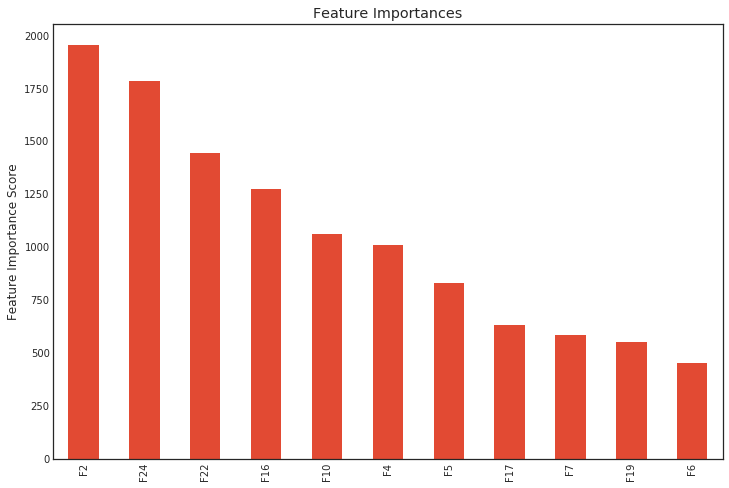

In [107]:
xgb_reduced = XGBClassifier(**xgb_reduced_params)
model_fit(xgb_reduced, x_train_reduced, x_train_reduced.columns.values)

In [108]:
xgb_reduced = XGBClassifier(**xgb_reduced_params)

gs_md_mcw = {
    "max_depth": range(3, 9, 1),
    "min_child_weight": range(1, 6, 2)
}

gs_md_mcw = GridSearchCV(estimator=xgb_reduced, param_grid=gs_md_mcw, cv=n_splits, scoring="roc_auc", verbose=1)
gs_md_mcw.fit(x_train_reduced, y_train_reduced)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=229,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 4, 5, 6, 7, 8], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [109]:
print gs_md_mcw.best_params_
print gs_md_mcw.best_score_

{'max_depth': 7, 'min_child_weight': 1}
0.7592573880980192


In [110]:
xgb_reduced = XGBClassifier(**xgb_reduced_params)

gs_gamma = {
    "gamma": [(i / 10.0) for i in range(0, 5)]
}

gs_gamma = GridSearchCV(estimator=xgb_reduced, param_grid=gs_gamma, cv=n_splits, scoring="roc_auc")
gs_gamma.fit(x_train_reduced, y_train_reduced)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=229,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [111]:
print gs_gamma.best_params_
print gs_gamma.best_score_

{'gamma': 0.0}
0.7592573880980192


In [ ]:
xgb_reduced = XGBClassifier(**xgb_reduced_params)

gs_ss_cb = {
    "subsample": [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
    "colsample_bytree": [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
}

gs_ss_cb = GridSearchCV(estimator=xgb_reduced, param_grid=gs_ss_cb, cv=n_splits, scoring="roc_auc", verbose=1)
gs_ss_cb.fit(x_train_reduced, y_train_reduced)

Fitting 5 folds for each of 121 candidates, totalling 605 fits


In [ ]:
print gs_ss_cb.best_params_
print gs_ss_cb_.best_score_

[0]	train-auc:0.588732+0.0445711	test-auc:0.556247+0.0311332
[1]	train-auc:0.623309+0.0167707	test-auc:0.590098+0.0277272
[2]	train-auc:0.653503+0.0205951	test-auc:0.605385+0.0186744
[3]	train-auc:0.68926+0.0161559	test-auc:0.623131+0.0264495
[4]	train-auc:0.705613+0.0192298	test-auc:0.632425+0.0231408
[5]	train-auc:0.722734+0.0227619	test-auc:0.640985+0.0243647
[6]	train-auc:0.743683+0.0123186	test-auc:0.653325+0.0200526
[7]	train-auc:0.757845+0.0166277	test-auc:0.66298+0.0273795
[8]	train-auc:0.768449+0.0178894	test-auc:0.664696+0.0219355
[9]	train-auc:0.778746+0.0199252	test-auc:0.667579+0.0182021
[10]	train-auc:0.787262+0.0176863	test-auc:0.672672+0.0164161
[11]	train-auc:0.799912+0.0169491	test-auc:0.681199+0.0151337
[12]	train-auc:0.812346+0.0215248	test-auc:0.683189+0.0213145
[13]	train-auc:0.823799+0.0151065	test-auc:0.685175+0.0226265
[14]	train-auc:0.831566+0.0134702	test-auc:0.692093+0.0251216
[15]	train-auc:0.839317+0.0149714	test-auc:0.696895+0.028448
[16]	train-auc:0.8473

[131]	train-auc:0.985147+0.001368	test-auc:0.746219+0.0219636
[132]	train-auc:0.985415+0.00125046	test-auc:0.746416+0.0222086
[133]	train-auc:0.985639+0.00130871	test-auc:0.747364+0.0217226
[134]	train-auc:0.985756+0.00127722	test-auc:0.747115+0.0216481
[135]	train-auc:0.985916+0.00137565	test-auc:0.746238+0.0218985
[136]	train-auc:0.986136+0.0013386	test-auc:0.746371+0.0223992
[137]	train-auc:0.986411+0.00141939	test-auc:0.746447+0.0228062
[138]	train-auc:0.986625+0.00125654	test-auc:0.74689+0.0224862
[139]	train-auc:0.986826+0.00119185	test-auc:0.747012+0.0221535
[140]	train-auc:0.987018+0.00126022	test-auc:0.746757+0.0223804
[141]	train-auc:0.987195+0.00132105	test-auc:0.747325+0.0229101
[142]	train-auc:0.987414+0.00138701	test-auc:0.746967+0.0232305
[143]	train-auc:0.987705+0.00139651	test-auc:0.746667+0.0233493
[144]	train-auc:0.987889+0.00137269	test-auc:0.746945+0.0235182
[145]	train-auc:0.988117+0.0013919	test-auc:0.747408+0.0230846
[146]	train-auc:0.988311+0.00133633	test-auc:

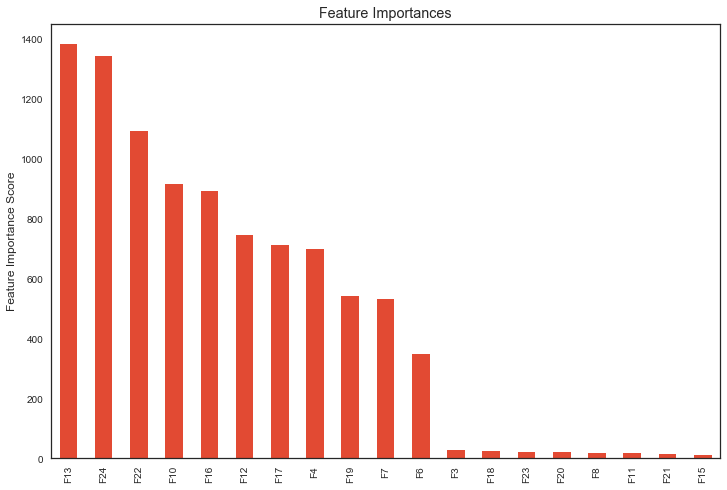

In [320]:
model_fit(xgb_base, x_train_base, x_train_base.columns.values)

Finally, let's tune our BaggingClassifier model using a parameter tuned XGBClassifier as the base estimator.

In [56]:
def get_tuned_xgb_copy():
    """ 
    Returns a fresh copy of our parameter tuned XGBClassifier, in case someone
    wants to re-run this notebook so the optimized parameters are saved.
    """
    return XGBClassifier(learning_rate=0.1,
                         n_estimators=345,
                         max_depth=8,
                         min_child_weight=2,
                         gamma=0.2,
                         subsample=0.6,
                         colsample_bytree=0.5,
                         objective="binary:logistic",
                         n_jobs=-1,
                         scale_pos_weight=1,
                         random_state=seed)

In [9]:
bag_param_grid = {
    "max_samples": [0.6, 0.7, 0.8,],
    "max_features": [0.7, 0.75, 0.8],
    "n_estimators": range(30, 70 + 1, 10)
}
 
xgb_bag = get_tuned_xgb_copy()
xgb_bagger = BaggingClassifier(base_estimator=xgb_bag, n_estimators=50, max_samples=0.7, max_features=0.75, \
                              bootstrap_features=True)

gs_xgb_bagger = GridSearchCV(estimator=xgb_bagger, param_grid=bag_param_grid, cv=n_splits, scoring="roc_auc")

In [ ]:
gs_xgb_bagger.fit(x_train_base, y_train_base)

In [ ]:
print gs_xgb_bagger.best_params_
print gs_xgb_bagger.best_score_

In [ ]:
xgb_bagger = BaggingClassifier(base_estimator=xgb_bag, n_estimators=50, max_samples=0.7, max_features=0.75, \
                              bootstrap_features=True)

In [ ]:
# TODO: Run tune on desktop PC (computationally expensive)

### XGB Modeling

With our tuned parameters, we'll now actually create, fit, train, and store predictions for the 3 XGBClassifier model variations described above.

In [75]:
# Raw data
xgb_raw = get_tuned_xgb_copy()
xgb_raw = train_and_save_base_learner_preds(xgb_raw, folds, x_train_raw, y_train_raw, test_raw, "xgboost_raw")

CPU times: user 7.69 s, sys: 1.56 s, total: 9.26 s
Wall time: 2.4 s
CPU times: user 7.62 s, sys: 1.54 s, total: 9.16 s
Wall time: 2.29 s
CPU times: user 7.89 s, sys: 1.91 s, total: 9.8 s
Wall time: 2.64 s
CPU times: user 7.78 s, sys: 1.73 s, total: 9.52 s
Wall time: 2.41 s
CPU times: user 7.55 s, sys: 1.59 s, total: 9.15 s
Wall time: 2.33 s


In [59]:
# There seems to be a parallelization issue w/ XGBClassifier when trying to obtain a CV score, thus we use only 1 core
xgb_raw_cv = get_cross_val_score(xgb_raw, x_train_raw, y_train_raw, n_splits, run_parallel=False)

Cross validation score: 0.752946642875 +/- 0.00490805565511
Raw scores: [ 0.75409323  0.75685271  0.74511919  0.75873599  0.74993209]


In [11]:
# With baseline data
xgb_base = get_tuned_xgb_copy()
xgb_base = train_and_save_base_learner_preds(xgb_base, folds, x_train_base, y_train_base, test_base, "xgboost_base")

CPU times: user 6.27 s, sys: 1.46 s, total: 7.73 s
Wall time: 1.94 s
CPU times: user 5.98 s, sys: 1.41 s, total: 7.39 s
Wall time: 1.87 s
CPU times: user 6.12 s, sys: 1.51 s, total: 7.63 s
Wall time: 1.98 s
CPU times: user 6.13 s, sys: 1.55 s, total: 7.69 s
Wall time: 2.05 s
CPU times: user 6.08 s, sys: 1.49 s, total: 7.57 s
Wall time: 1.94 s


In [12]:
xgb_base_cv = get_cross_val_score(xgb_base, x_train_base, y_train_base, n_splits, run_parallel=False)

Cross validation score: 0.758965265001 +/- 0.0044137786577
Raw scores: [ 0.76202306  0.75019668  0.76073913  0.76056439  0.76130306]


In [13]:
# Finally, predict our probabilities.
xgb_base.fit(x_train_base, y_train_base)
xgb_base_probs = xgb_base.predict_proba(test_base)[:,1]
print xgb_base_probs

[ 0.97352272  0.69323683  0.97338152 ...,  0.98168164  0.99494499
  0.97807866]


In [15]:
# save a copy of the predictions
submission = pd.DataFrame({"id": test_ids.id, "Y": xgb_base_probs})
submission.to_csv("./submissions/xgboost_base_lone.csv", index=False, columns=["id", "Y"])

In [26]:
# With polynomial features
xgb_poly = get_tuned_xgb_copy()
xgb_poly = train_and_save_base_learner_preds(xgb_poly, folds, x_train_poly, y_train_poly, test_poly, "xgboost_poly")

CPU times: user 8.09 s, sys: 1.56 s, total: 9.65 s
Wall time: 2.27 s
CPU times: user 7.81 s, sys: 1.47 s, total: 9.28 s
Wall time: 2.2 s
CPU times: user 8.01 s, sys: 1.47 s, total: 9.47 s
Wall time: 2.16 s
CPU times: user 8.02 s, sys: 1.48 s, total: 9.5 s
Wall time: 2.18 s
CPU times: user 8.09 s, sys: 1.51 s, total: 9.59 s
Wall time: 2.19 s


In [27]:
xgb_poly_cv = get_cross_val_score(xgb_poly, x_train_poly, y_train_poly, n_splits, run_parallel=False)

Cross validation score: 0.745601533629 +/- 0.00395136757867
Raw scores: [ 0.74112726  0.7418853   0.74615411  0.74670364  0.75213736]


In [28]:
# Finally, predict our probabilities.
xgb_poly.fit(x_train_poly, y_train_poly)
xgb_poly_probs = xgb_poly.predict_proba(test_poly)[:,1]
print xgb_poly_probs

[ 0.9757967   0.83976942  0.99041665 ...,  0.8301931   0.99723142
  0.96768582]


In [29]:
# save a copy of the predictions
submission = pd.DataFrame({"id": test_ids.id, "Y": xgb_poly_probs})
submission.to_csv("./submissions/xgboost_poly_lone.csv", index=False, columns=["id", "Y"])

In [10]:
# Bagged classifier
xgb_bag = BaggingClassifier(base_estimator=get_tuned_xgb_copy(), n_estimators=50, max_samples=0.7, max_features=0.75, \
                              bootstrap_features=True)
xgb_bag = train_and_save_base_learner_preds(xgb_bag, folds, x_train_base, y_train_base, test_base, "xgboost_bag")

CPU times: user 4min 12s, sys: 1min 3s, total: 5min 15s
Wall time: 1min 21s
CPU times: user 4min 9s, sys: 1min 3s, total: 5min 13s
Wall time: 1min 22s
CPU times: user 4min 12s, sys: 1min 5s, total: 5min 18s
Wall time: 1min 23s
CPU times: user 4min 15s, sys: 1min 6s, total: 5min 21s
Wall time: 1min 24s
CPU times: user 4min 11s, sys: 1min 5s, total: 5min 16s
Wall time: 1min 22s


In [11]:
xgb_bag_cv = get_cross_val_score(xgb_bag, x_train_base, y_train_base, n_splits, run_parallel=False)

Cross validation score: 0.765461690614 +/- 0.00809893237118
Raw scores: [ 0.76912311  0.77508948  0.75436082  0.77130436  0.75743068]


In [12]:
# Finally, predict our probabilities.
xgb_bag.fit(x_train_base, y_train_base)
xgb_bag_probs = xgb_bag.predict_proba(test_base)[:,1]
print xgb_bag_probs

[ 0.98064233  0.77828402  0.94634236 ...,  0.92761304  0.98266136
  0.97643858]


#### XGB Prediction Correlation Matrix (Varied Data Sets)

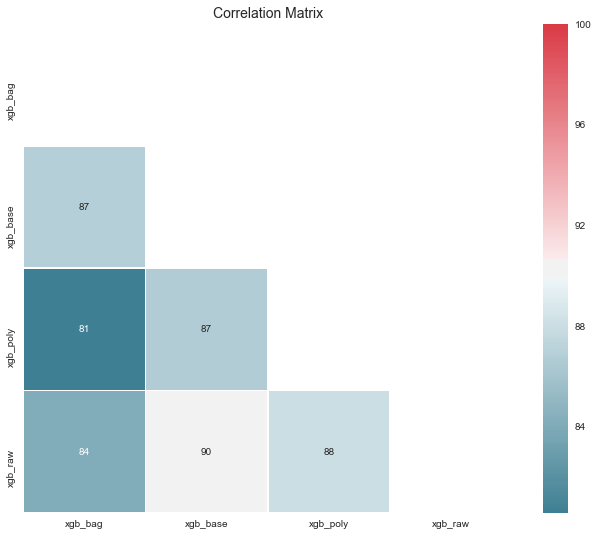

In [80]:
xgb_preds = {
    "xgb_raw": get_preds("xgboost_raw")[0],
    "xgb_base": get_preds("xgboost_base")[0],
    "xgb_poly": get_preds("xgboost_poly")[0],
    "xgb_bag": get_preds("xgboost_bag")[0]
}

show_pearson_corr(xgb_preds, dict_vals_are_models=False)

### ExtraTreesClassifier

In [55]:
et_param_grid = {
    "max_depth": range(6, 12 + 1, 2),
    "n_estimators": range(150, 350 + 1, 50)
}

et = ExtraTreesClassifier(max_depth=6, n_estimators=150, n_jobs=-1, criterion="entropy")
gs_et = GridSearchCV(estimator=et, param_grid=et_param_grid, cv=n_splits, scoring="roc_auc")
gs_et.fit(x_train_base, y_train_base)

GridSearchCV(cv=5, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=6, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [150, 200, 250, 300, 350], 'max_depth': [6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [56]:
print gs_et.best_params_
print gs_et.best_score_

{'n_estimators': 250, 'max_depth': 12}
0.657812396697


In [60]:
# Step two
et_param_grid_2 = {
    "max_depth": range(12, 20 + 1, 2)
}

et_2 = ExtraTreesClassifier(max_depth=12, n_estimators=250, n_jobs=-1, criterion="entropy")
gs_et_2 = GridSearchCV(estimator=et_2, param_grid=et_param_grid_2, cv=n_splits, scoring="roc_auc")
gs_et_2.fit(x_train_base, y_train_base)

GridSearchCV(cv=5, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=12, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [12, 14, 16, 18, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [61]:
print gs_et.best_params_
print gs_et.best_score_

{'n_estimators': 250, 'max_depth': 12}
0.657812396697


In [16]:
get_cross_val_score(ExtraTreesClassifier(max_depth=12, n_estimators=250, n_jobs=-1, criterion="entropy"), x_train_base, y_train_base, n_splits)

Cross validation score: 0.658994376998 +/- 0.0162024899885
Raw scores: [ 0.66693004  0.65553248  0.67156773  0.62885771  0.67208392]


array([ 0.66693004,  0.65553248,  0.67156773,  0.62885771,  0.67208392])

In [79]:
et_base = ExtraTreesClassifier(max_depth=12, n_estimators=250, n_jobs=-1, criterion="entropy")
et_base = train_and_save_base_learner_preds(et_base, folds, x_train_base, y_train_base, test_base, "extra_trees_base")

CPU times: user 2.03 s, sys: 132 ms, total: 2.16 s
Wall time: 925 ms
CPU times: user 2.13 s, sys: 127 ms, total: 2.26 s
Wall time: 948 ms
CPU times: user 2.33 s, sys: 120 ms, total: 2.45 s
Wall time: 1.08 s
CPU times: user 2.18 s, sys: 121 ms, total: 2.31 s
Wall time: 970 ms
CPU times: user 2.1 s, sys: 110 ms, total: 2.21 s
Wall time: 935 ms


### AdaboostClassifier

In [8]:
ada_param_grid = {
    "learning_rate": [1, 1.1, 1.2, 1.3, 1.4, 1.5],
    "n_estimators": range(300, 400, 10)
}

ada = AdaBoostClassifier(n_estimators=150, learning_rate=0.1)
gs_ada = GridSearchCV(estimator=ada, param_grid=ada_param_grid, cv=n_splits, scoring="roc_auc")
gs_ada.fit(x_train_base, y_train_base)

GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=150, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [300, 310, 320, 330, 340, 350, 360, 370, 380, 390], 'learning_rate': [1, 1.1, 1.2, 1.3, 1.4, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [9]:
print gs_ada.best_params_
print gs_ada.best_score_

{'n_estimators': 390, 'learning_rate': 1.5}
0.701561241805


In [10]:
ada_param_grid_2 = {
    "learning_rate": [1.45, 1.5, 1.55],
    "n_estimators": [385, 390, 395]
}

ada_2 = AdaBoostClassifier(n_estimators=390, learning_rate=1.5)
gs_ada_2 = GridSearchCV(estimator=ada_2, param_grid=ada_param_grid_2, cv=n_splits, scoring="roc_auc")
gs_ada_2.fit(x_train_base, y_train_base)

GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=390, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [385, 390, 395], 'learning_rate': [1.45, 1.5, 1.55]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [11]:
print gs_ada_2.best_params_
print gs_ada_2.best_score_

{'n_estimators': 395, 'learning_rate': 1.55}
0.704140678649


In [14]:
ada_tuned = AdaBoostClassifier(n_estimators=395, learning_rate=1.55)
ada_tuned = train_and_save_base_learner_preds(ada_tuned, folds, x_train_base, y_train_base, test_base, "adaboost_base")

CPU times: user 4.31 s, sys: 8.68 ms, total: 4.32 s
Wall time: 4.32 s
CPU times: user 4.21 s, sys: 5.1 ms, total: 4.21 s
Wall time: 4.21 s
CPU times: user 4.24 s, sys: 4.18 ms, total: 4.24 s
Wall time: 4.24 s
CPU times: user 4.19 s, sys: 4.51 ms, total: 4.2 s
Wall time: 4.19 s
CPU times: user 4.22 s, sys: 4.25 ms, total: 4.23 s
Wall time: 4.23 s


In [15]:
ada_tuned_cv = get_cross_val_score(ada_tuned, x_train_base, y_train_base, n_splits)

Cross validation score: 0.70414215576 +/- 0.01160028695
Raw scores: [ 0.71407938  0.69589411  0.70874949  0.68574588  0.71624191]


### KNeighborsClassifier

We'll train instances of KNeighbors with **n_neighbors** set to $2^n$ for **n = [1, 10]**.

In [67]:
knn_models = dict()

for n in range(1, 10 + 1):
    knn_i = KNeighborsClassifier(n_neighbors=2**n, n_jobs=-1)
    knn_i = train_and_save_base_learner_preds(knn_i, 
                                              folds, 
                                              x_train_base, 
                                              y_train_base, 
                                              test_base, 
                                              "knn_{}".format(2**n), 
                                              timeit=False)
    knn_models["knn_{}".format(2**n)] = knn_i
    print ("'n_neighbors'={}: ".format(2**n)),
    get_cross_val_score(knn_i, x_train_base, y_train_base, n_splits)

'n_neighbors'=2:  Cross validation score: 0.573434775043 +/- 0.0215055478114
Raw scores: [ 0.56259454  0.59927742  0.59888489  0.54767778  0.55873925]
'n_neighbors'=4:  Cross validation score: 0.590499136721 +/- 0.0217076333611
Raw scores: [ 0.61750827  0.59411804  0.60925007  0.56118483  0.57043447]
'n_neighbors'=8:  Cross validation score: 0.610623922154 +/- 0.0283743924322
Raw scores: [ 0.65312922  0.60882293  0.62842129  0.5716876   0.59105856]
'n_neighbors'=16:  Cross validation score: 0.624549248213 +/- 0.0129561138453
Raw scores: [ 0.62794604  0.6354268   0.63109468  0.59914151  0.62913721]
'n_neighbors'=32:  Cross validation score: 0.635463475798 +/- 0.0167329190449
Raw scores: [ 0.64259775  0.63234569  0.64453252  0.60471873  0.65312269]
'n_neighbors'=64:  Cross validation score: 0.626697022758 +/- 0.0260453337146
Raw scores: [ 0.64346299  0.59740765  0.64831594  0.59261885  0.65167967]
'n_neighbors'=128:  Cross validation score: 0.627894229991 +/- 0.0251870821371
Raw scores: 

In [66]:
# TODO: maybe explore other models

## Choosing optimal base learners

We'll first see how each base learner performs by itself, then display the pearson correlation matrix against each base learner's predictions.

In [68]:
# Process for parameters used for each base learner is documented in "layer_1_models.ipynb".
rfc = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=1000, n_jobs=-1)
lr = LogisticRegression(C=100, tol=1e-05, solver="liblinear")
et = ExtraTreesClassifier(max_depth=12, n_estimators=250, n_jobs=-1, criterion="entropy")
ada = AdaBoostClassifier(n_estimators=395, learning_rate=1.55)
xgb = get_tuned_xgb_copy()

In [69]:
base_learners = {
    "rfc": rfc,
    "lr": lr,
    "et": et,
    "ada": ada,
    "xgb": xgb
}

base_learners.update(knn_models)

all_preds = pd.DataFrame(np.zeros((test_base.shape[0], len(base_learners))), columns=list(base_learners.keys()))

for name, model in base_learners.items():
    model.fit(x_train_base, y_train_base)
    all_preds[name] = model.predict_proba(test_base)[:,1]

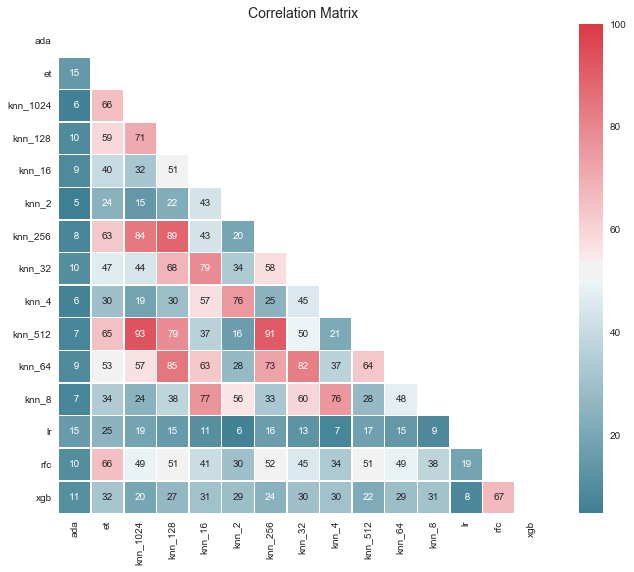

In [78]:
all_preds = all_preds.reindex_axis(sorted(all_preds.columns.values), axis=1)

ax = corrmat(all_preds.corr())
plt.show()

Excluding the correlation values of different KNN instances, we can see that a majority of the base learners aren't highly correlated, so an ensemble including **all** of these base learners will likely outperform any of the base learner's lone predictions, through combining each base learner's respective predictive 
strengths.

Based on my most recent Kaggle submissions, it seems ML-Ensemble produces better performing predictions. Because of this, I'll generate another set of meta features with the same tuned parameters, but predicting using mlens.

In [22]:
from mlens.ensemble import SuperLearner
from sklearn.metrics import roc_auc_score

In [52]:
rf_mlens = RandomForestClassifier(criterion='entropy', max_features=10, n_estimators=1000, n_jobs=-1)

# Raw
rf_raw_mlens = train_and_save_base_learner_preds(rf_mlens, 
                                                       folds, 
                                                       x_train_raw, y_train_raw, test_raw, 
                                                       "random_forest_raw",
                                                       timeit=False, 
                                                       mlens=True)
rf_raw_mlens_cv = get_cross_val_score(rf_raw_mlens, x_train_raw, y_train_raw, n_splits)

# Log
rf_log_mlens = train_and_save_base_learner_preds(rf_mlens, 
                                                       folds, 
                                                       x_train_log, y_train_log, test_log, 
                                                       "random_forest_log",
                                                       timeit=False, 
                                                       mlens=True)
rf_log_mlens_cv = get_cross_val_score(rf_log_mlens, x_train_log, y_train_log, n_splits)

CPU times: user 1min 56s, sys: 8.85 ms, total: 1min 56s
Wall time: 1min 58s
CPU times: user 1min 55s, sys: 679 µs, total: 1min 55s
Wall time: 1min 57s
CPU times: user 1min 55s, sys: 4.71 ms, total: 1min 55s
Wall time: 1min 57s
CPU times: user 1min 54s, sys: 8.45 ms, total: 1min 54s
Wall time: 1min 55s
CPU times: user 1min 55s, sys: 468 µs, total: 1min 55s
Wall time: 1min 56s
Cross validation score: 0.771108710694092 +/- 0.011731124909709916
Raw scores: [0.76757834 0.78622451 0.75820418 0.75994142 0.78359511]
CPU times: user 1min 33s, sys: 11.9 ms, total: 1min 33s
Wall time: 1min 36s
CPU times: user 1min 28s, sys: 26.1 ms, total: 1min 28s
Wall time: 1min 39s
CPU times: user 1min 29s, sys: 0 ns, total: 1min 29s
Wall time: 1min 42s
CPU times: user 1min 27s, sys: 18.2 ms, total: 1min 27s
Wall time: 1min 36s
CPU times: user 1min 28s, sys: 11.1 ms, total: 1min 28s
Wall time: 1min 33s
Cross validation score: 0.7670154592380092 +/- 0.013308737233868325
Raw scores: [0.76937382 0.782539   0.7478

NameError: name 'y_train_poy' is not defined

In [55]:
# Typo lmao, just running the poly transformation in this block separately since it takes a while
# Poly
rf_poly_mlens = train_and_save_base_learner_preds(rf_mlens, 
                                                       folds, 
                                                       x_train_poly, y_train_poly, test_poly, 
                                                       "random_forest_poly",
                                                       timeit=False, 
                                                       mlens=True)
rf_poly_mlens_cv = get_cross_val_score(rf_poly_mlens, x_train_poly, y_train_poly, n_splits)

CPU times: user 2min 16s, sys: 156 ms, total: 2min 16s
Wall time: 2min 38s
CPU times: user 2min 15s, sys: 40.2 ms, total: 2min 15s
Wall time: 2min 31s
CPU times: user 2min 13s, sys: 1.49 ms, total: 2min 13s
Wall time: 2min 15s
CPU times: user 2min 13s, sys: 1.39 ms, total: 2min 13s
Wall time: 2min 15s
CPU times: user 2min 13s, sys: 8.66 ms, total: 2min 13s
Wall time: 2min 16s
Cross validation score: 0.7630587133668844 +/- 0.016673517355080603
Raw scores: [0.75718615 0.78210342 0.74633306 0.74603677 0.78363416]


In [57]:
lr_mlens = LogisticRegression(C=100, tol=1e-05, solver="liblinear", random_state=seed)

# Log
lr_log_mlens = train_and_save_base_learner_preds(lr_mlens,
                                                       folds,
                                                       x_train_log, y_train_log, test_log,
                                                       "logistic_regression_log",
                                                       mlens=True)
lr_log_mlens_cv = get_cross_val_score(lr_log_mlens, x_train_log, y_train_log, n_splits)

CPU times: user 346 ms, sys: 7 µs, total: 346 ms
Wall time: 384 ms
CPU times: user 356 ms, sys: 0 ns, total: 356 ms
Wall time: 399 ms
CPU times: user 336 ms, sys: 0 ns, total: 336 ms
Wall time: 362 ms
CPU times: user 339 ms, sys: 0 ns, total: 339 ms
Wall time: 365 ms
CPU times: user 343 ms, sys: 0 ns, total: 343 ms
Wall time: 368 ms
Cross validation score: 0.5457534068030371 +/- 0.023000862577507126
Raw scores: [0.5643436  0.55359772 0.50611494 0.53533056 0.56938022]


In [59]:
xgb_mlens = get_tuned_xgb_copy()

# Raw
xgb_raw_mlens = train_and_save_base_learner_preds(xgb_mlens,
                                                  folds,
                                                  x_train_raw, y_train_raw, test_raw,
                                                   "xgboost_raw",
                                                  mlens=True)
xgb_raw_mlens_cv = get_cross_val_score(xgb_raw_mlens, x_train_raw, y_train_raw, n_splits, run_parallel=False)

# Base
xgb_base_mlens = train_and_save_base_learner_preds(xgb_mlens,
                                                   folds,
                                                   x_train_base, y_train_base, test_base,
                                                   "xgboost_base",
                                                   mlens=True)
xgb_base_mlens_cv = get_cross_val_score(xgb_base_mlens, x_train_base, y_train_base, n_splits, run_parallel=False)

# Poly
xgb_poly_mlens = train_and_save_base_learner_preds(xgb_mlens,
                                                   folds,
                                                   x_train_poly, y_train_poly, test_poly,
                                                   "xgboost_poly",
                                                   mlens=True)
xgb_poly_mlens_cv = get_cross_val_score(xgb_poly_mlens, x_train_poly, y_train_poly, n_splits, run_parallel=False)

# Bag
xgb_bag = BaggingClassifier(base_estimator=xgb_mlens, n_estimators=50, max_samples=0.7, max_features=0.75, \
                              bootstrap_features=True)

xgb_bag_mlens = train_and_save_base_learner_preds(xgb_bag,
                                                  folds,
                                                  x_train_base, y_train_base, test_base,
                                                  "xgboost_bag",
                                                  mlens=True)
xgb_bag_mlens_cv = get_cross_val_score(xgb_bag_mlens, x_train_base, y_train_base, n_splits, run_parallel=False)

CPU times: user 9.92 s, sys: 27.5 ms, total: 9.95 s
Wall time: 10.5 s
CPU times: user 10.5 s, sys: 35.4 ms, total: 10.5 s
Wall time: 10.7 s
CPU times: user 10.4 s, sys: 31.5 ms, total: 10.5 s
Wall time: 10.9 s
CPU times: user 10.4 s, sys: 39.4 ms, total: 10.4 s
Wall time: 10.6 s
CPU times: user 10.4 s, sys: 35.4 ms, total: 10.4 s
Wall time: 10.5 s
Cross validation score: 0.7529464731081388 +/- 0.0049081599371427545
Raw scores: [0.75409323 0.75685271 0.74511919 0.75873599 0.74993124]
CPU times: user 8.39 s, sys: 27.6 ms, total: 8.42 s
Wall time: 8.54 s
CPU times: user 8.26 s, sys: 39.3 ms, total: 8.3 s
Wall time: 8.39 s
CPU times: user 8.22 s, sys: 35.4 ms, total: 8.25 s
Wall time: 8.34 s
CPU times: user 8.18 s, sys: 4 ms, total: 8.18 s
Wall time: 8.28 s
CPU times: user 8.22 s, sys: 19.7 ms, total: 8.24 s
Wall time: 8.33 s
Cross validation score: 0.7589652650008001 +/- 0.00441377865770259
Raw scores: [0.76202306 0.75019668 0.76073913 0.76056439 0.76130306]
CPU times: user 10.7 s, sys: 2

In [60]:
ada_mlens = AdaBoostClassifier(n_estimators=395, learning_rate=1.55)

# Base
ada_base_mlens = train_and_save_base_learner_preds(ada_mlens, 
                                                   folds, 
                                                   x_train_base, y_train_base, test_base, 
                                                   "adaboost_base",
                                                   mlens=True)
ada_base_mlens_cv = get_cross_val_score(ada_base_mlens, x_train_base, y_train_base, n_splits)

CPU times: user 10.4 s, sys: 4.07 ms, total: 10.4 s
Wall time: 10.5 s
CPU times: user 9.92 s, sys: 176 µs, total: 9.92 s
Wall time: 10 s
CPU times: user 9.71 s, sys: 128 µs, total: 9.71 s
Wall time: 9.79 s
CPU times: user 9.65 s, sys: 187 µs, total: 9.65 s
Wall time: 9.72 s
CPU times: user 9.91 s, sys: 4.04 ms, total: 9.92 s
Wall time: 10.3 s
Cross validation score: 0.7041421557601281 +/- 0.011600286950032486
Raw scores: [0.71407938 0.69589411 0.70874949 0.68574588 0.71624191]


In [61]:
et_mlens = ExtraTreesClassifier(max_depth=12, n_estimators=250, n_jobs=-1, random_state=seed, criterion="entropy")
et_base_mlens = train_and_save_base_learner_preds(et_mlens, 
                                                  folds, 
                                                  x_train_base, y_train_base, test_base, 
                                                  "extra_trees_base",
                                                  mlens=True)
et_base_mlens_cv = get_cross_val_score(et_base_mlens, x_train_base, y_train_base, n_splits)

CPU times: user 3.32 s, sys: 47 µs, total: 3.32 s
Wall time: 3.36 s
CPU times: user 3.41 s, sys: 51 µs, total: 3.41 s
Wall time: 3.45 s
CPU times: user 3.35 s, sys: 53 µs, total: 3.35 s
Wall time: 3.37 s
CPU times: user 3.36 s, sys: 3.99 ms, total: 3.36 s
Wall time: 3.39 s
CPU times: user 3.45 s, sys: 63 µs, total: 3.45 s
Wall time: 3.48 s
Cross validation score: 0.6552834053985692 +/- 0.01665215010591389
Raw scores: [0.66506618 0.64908158 0.67635906 0.62707827 0.65883194]
